In [163]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [164]:
path_train = "train_1"

wag_prob = pd.read_parquet(path_train + "/wagons_probeg_ownersip.parquet").convert_dtypes()
wag_param = pd.read_parquet(path_train + "/wag_params.parquet").convert_dtypes()
dislok_wagons = pd.read_parquet(path_train + "/dislok_wagons.parquet").convert_dtypes()

target = pd.read_csv(path_train +'/target/y_train.csv').convert_dtypes()
to_predict = pd.read_csv(path_train +'/target/y_predict.csv').convert_dtypes()

In [165]:
# & (target['month'] == '2022-09-01')
target[(target['target_month'] == 1) & (target['wagnum'] == 1072)]

,wagnum,month,target_month,target_day
34411,1072,2022-08-01,1,0


In [138]:
dislok_wagons[(dislok_wagons['date_pl_rem'] > '2022-08-01') & (dislok_wagons['date_pl_rem'] < '2023-01-01') & (dislok_wagons['wagnum'] == 3980)]

,plan_date,wagnum,date_kap,date_dep,kod_vrab,date_pl_rem,id_road_disl,st_id_dest,id_road_dest,st_id_send,id_road_send,ost_prob,isload,fr_id,last_fr_id,distance
83049,2022-08-01,3980,NaT,2019-09-02,0,2022-09-02,25,22,25,5722,25,16844,0,1475,1475,-1
83050,2022-08-02,3980,NaT,2019-09-02,0,2022-09-02,25,22,25,5722,25,16844,0,5032,1475,-1
83051,2022-08-03,3980,NaT,2019-09-02,0,2022-09-02,25,22,25,5722,25,16844,0,5032,1475,-1
83052,2022-08-04,3980,NaT,2019-09-02,0,2022-09-02,25,22,25,5722,25,16844,0,5032,1475,-1
83053,2022-08-05,3980,NaT,2019-09-02,0,2022-09-02,25,22,25,5722,25,16844,0,5032,1475,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1052176,2023-01-27,3980,NaT,2019-09-02,0,2022-09-02,44,22,44,11412,42,144251,1,1671,1671,3846
1052177,2023-01-28,3980,NaT,2019-09-02,0,2022-09-02,44,22,44,11412,42,144251,1,1671,1671,3792
1052178,2023-01-29,3980,NaT,2019-09-02,0,2022-09-02,44,22,44,11412,42,144251,1,1671,1671,3860
1052179,2023-01-30,3980,NaT,2019-09-02,0,2022-09-02,44,22,44,11412,42,144251,1,1671,1671,3801


+ Можно считать сумму distance, т.к не для всех данных есть остаточный пробег

In [182]:
train_target = target[target["month"] == "2022-12-01"].drop("month", axis=1)
dis_train = dislok_wagons[dislok_wagons["plan_date"] < "2022-12-01"]

+ Ковертирую в дни, т.к дальше были проблемы с datetime и null
+ ВНИМАНИЕ. НУЛЫ ЗАПОЛНИЛ -1

In [ ]:
# dislok_wagons = pd.read_parquet(path_train + "/dislok_wagons.parquet").convert_dtypes()

# dis_train = dislok_wagons[dislok_wagons["plan_date"] < "2022-12-01"]

# base_date = pd.to_datetime("2023-02-01")
# days_from_kap_mean = (base_date - dis_train["date_kap"]).dt.days.mean()
# days_from_dep_mean = (base_date - dis_train["date_dep"]).dt.days.mean()

# dis_train["days_from_kap"] = (pd.to_datetime("2023-02-01") - dis_train["date_kap"]).dt.days
# dis_train["days_from_dep"] = (pd.to_datetime("2023-02-01") - dis_train["date_dep"]).dt.days
# dis_train["days_to_date_pl_rem"] = (base_date - dis_train["date_pl_rem"]).dt.days

# # Fill missing values with mean
# dis_train['days_from_kap'] = dis_train['days_from_kap'].fillna(-1)
# dis_train['days_from_dep'] = dis_train['days_from_dep'].fillna(-1)


# dis_train = dis_train.groupby('wagnum').agg({
#     'plan_date': ['last'], 
#     'days_from_kap': lambda x: x[x != -1].iloc[0] if (x != -1).any() else days_from_kap_mean,
#     'days_from_dep': lambda x: x[x != -1].iloc[0] if (x != -1).any() else days_from_dep_mean,
#     'days_to_date_pl_rem': lambda x: x[x.notnull()].iloc[-1] if x.notnull().any() else None,
#     'date_pl_rem': lambda x: x[x.notnull()].iloc[-1] if x.notnull().any() else None, # поменять
#     'distance': 'last',
#     'isload': 'last',
#     'ost_prob': 'last'
#     })


# dis_train.columns = ['plan_date', 'days_from_kap', 'days_to_date_pl_rem', 
#                     'days_from_dep', 'date_pl_rem', 'distance', 'isload', 'ost_prob']

In [183]:
# fill date_kap and date_dep with dt.days
base_date = pd.to_datetime("2023-02-01")
days_from_kap_mean = (base_date - dis_train["date_kap"]).dt.days.mean()
days_from_dep_mean = (base_date - dis_train["date_dep"]).dt.days.mean()

dis_train["days_from_kap"] = (pd.to_datetime("2023-02-01") - dis_train["date_kap"]).dt.days
dis_train["days_from_dep"] = (pd.to_datetime("2023-02-01") - dis_train["date_dep"]).dt.days
dis_train["days_to_date_pl_rem"] = (base_date - dis_train["date_pl_rem"]).dt.days

# Fill missing values with mean
dis_train['days_from_kap'] = dis_train['days_from_kap'].fillna(-1)
dis_train['days_from_dep'] = dis_train['days_from_dep'].fillna(-1)

C:\Users\mikha\AppData\Local\Temp\ipykernel_624\257535212.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dis_train["days_from_kap"] = (pd.to_datetime("2023-02-01") - dis_train["date_kap"]).dt.days
C:\Users\mikha\AppData\Local\Temp\ipykernel_624\257535212.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dis_train["days_from_dep"] = (pd.to_datetime("2023-02-01") - dis_train["date_dep"]).dt.days
C:\Users\mikha\AppData\Local\Temp\ipykernel_624\257535212.py:8: SettingWithCopyWarning: 
A value is trying t

In [184]:
dis_train['days_from_dep'].describe()

count    4.144917e+06
mean     9.216575e+02
std      4.865727e+02
min     -1.000000e+00
25%      5.880000e+02
50%      8.920000e+02
75%      1.179000e+03
max      3.483000e+03
Name: days_from_dep, dtype: float64

In [185]:
# Aggregation by wagnum. Agg by date_kap where it is not null
dis_train = dis_train.groupby('wagnum').agg({
    'plan_date': ['last'], 
    'days_from_kap': lambda x: x[x != -1].iloc[0] if (x != -1).any() else days_from_kap_mean,
    'days_from_dep': lambda x: x[x != -1].iloc[0] if (x != -1).any() else days_from_dep_mean,
    'days_to_date_pl_rem': lambda x: x[x.notnull()].iloc[-1] if x.notnull().any() else None,
    'date_pl_rem': lambda x: x[x.notnull()].iloc[-1] if x.notnull().any() else None, # поменять
    'distance': 'last',
    'isload': 'last',
    'ost_prob': 'last'
    })


dis_train.columns = ['plan_date', 'days_from_kap', 'days_from_dep', 'days_to_date_pl_rem',
                     'date_pl_rem', 'distance', 'isload', 'ost_prob']


In [186]:
dis_train.describe()

,days_from_kap,days_from_dep,days_to_date_pl_rem,distance,isload,ost_prob
count,33977.000000,33977.000000,33977.000000,33977.0,33977.0,32701.0
mean,2017.408877,975.945417,-335.204256,561.103217,0.448745,91492.039204
std,1158.618168,432.326593,298.393607,1267.058095,0.497373,71535.47264
min,171.000000,171.000000,-1412.000000,-1.0,0.0,-7225.0
25%,1104.000000,656.000000,-542.000000,-1.0,0.0,37386.0
50%,2043.687663,947.000000,-293.000000,-1.0,0.0,83777.0
75%,2043.687663,1180.000000,-108.000000,348.0,1.0,138554.0
max,6509.000000,3483.000000,2436.000000,10003.0,1.0,500000.0


### Train data

In [187]:
# Join train_target and dis_train
train = pd.merge(train_target, dis_train, how="inner", left_on="wagnum", right_on="wagnum")

In [188]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33977 entries, 0 to 33976
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   wagnum               33977 non-null  Int64         
 1   target_month         33977 non-null  Int64         
 2   target_day           33977 non-null  Int64         
 3   plan_date            33977 non-null  datetime64[ns]
 4   days_from_kap        33977 non-null  float64       
 5   days_from_dep        33977 non-null  float64       
 6   days_to_date_pl_rem  33977 non-null  int64         
 7   date_pl_rem          33977 non-null  datetime64[ns]
 8   distance             33977 non-null  Int64         
 9   isload               33977 non-null  Int64         
 10  ost_prob             32701 non-null  Int64         
dtypes: Int64(6), datetime64[ns](2), float64(2), int64(1)
memory usage: 3.3 MB


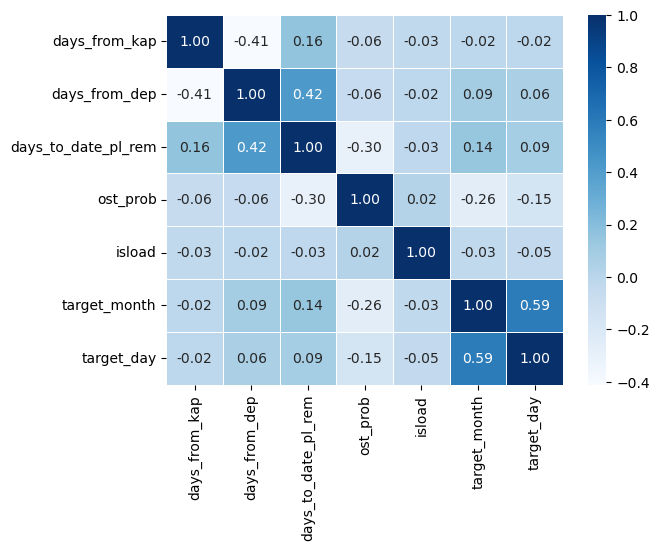

In [189]:
# Correlation between days_from_kap, days_from_dep and target_month, target_day
cr = train[["days_from_kap", "days_from_dep", 'days_to_date_pl_rem', "ost_prob", "isload", "target_month", "target_day"]].corr()
sns.heatmap(cr, annot=True, fmt=".2f", linewidths=.5, cmap='Blues')
plt.show()

#### Имейте в виду fillna средними значениями

In [190]:
days_from_kap_mean, days_from_dep_mean

(2043.6876631137293, 976.6791346362788)

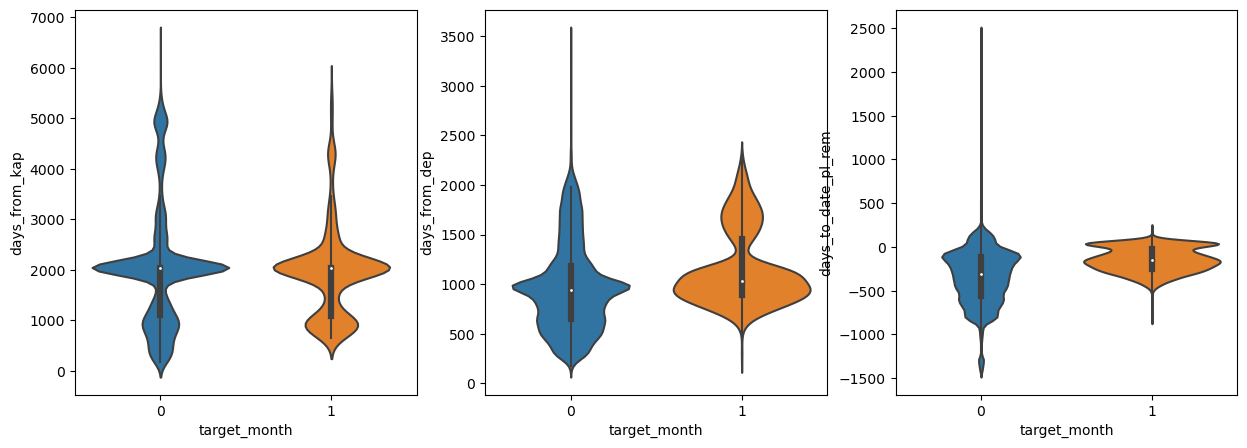

In [197]:
# Violin  between days_from_kap, days_from_dep and target_month, target_day
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.violinplot(x="target_month", y="days_from_kap", data=train, ax=ax[0])
sns.violinplot(x="target_month", y="days_from_dep", data=train, ax=ax[1])
sns.violinplot(x="target_month", y="days_to_date_pl_rem", data=train, ax=ax[2])
plt.show()

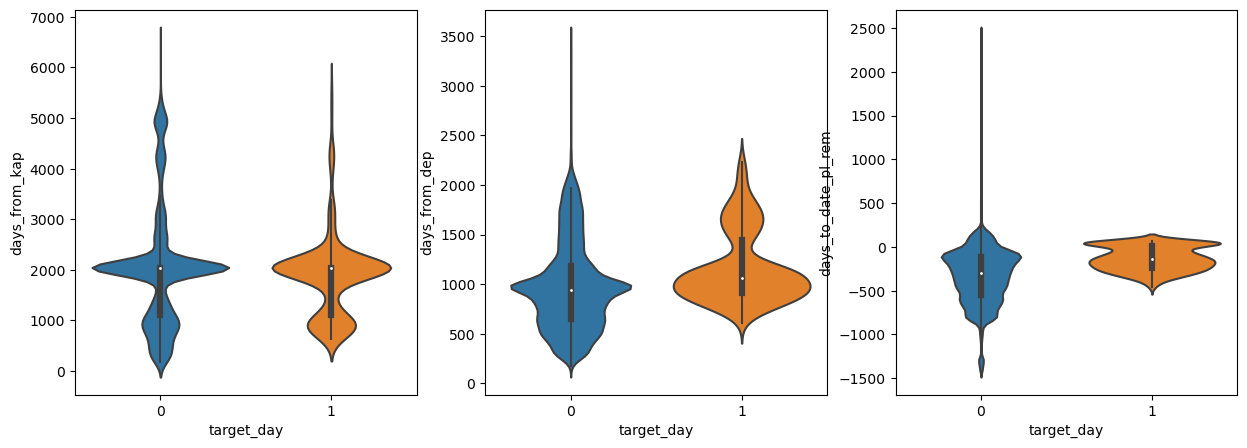

In [199]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.violinplot(x="target_day", y="days_from_kap", data=train, ax=ax[0])
sns.violinplot(x="target_day", y="days_from_dep", data=train, ax=ax[1])
sns.violinplot(x="target_day", y="days_to_date_pl_rem", data=train, ax=ax[2])
plt.show()

In [194]:
# Fill ost_prob
train['ost_prob'] = train['ost_prob'].fillna(-1)

In [195]:
X = train.drop(["wagnum", "target_month", "target_day", "plan_date", "date_pl_rem", "distance"], axis=1)
y = train[["target_month", "target_day"]]
X.head()

,days_from_kap,days_from_dep,days_to_date_pl_rem,isload,ost_prob
0,1080.000000,1968.0,-16,0,159916
1,851.000000,1767.0,-244,1,4516
2,2043.687663,1034.0,-61,0,1511
3,708.000000,1282.0,-387,0,30223
4,940.000000,1705.0,-155,0,153839


#### Создаем тестовую выборку

In [196]:
test_target = target[target["month"] == "2023-01-01"].drop("month", axis=1)
dis_test = dislok_wagons[dislok_wagons["plan_date"] < "2023-01-01"]

dis_test["days_from_kap"] = (pd.to_datetime("2023-02-01") - dis_test["date_kap"]).dt.days
dis_test["days_from_dep"] = (pd.to_datetime("2023-02-01") - dis_test["date_dep"]).dt.days

# Fill missing values with mean
dis_test['days_from_kap'] = dis_test['days_from_kap'].fillna(-1)
dis_test['days_from_dep'] = dis_test['days_from_dep'].fillna(-1)

dis_test = dis_test.groupby('wagnum').agg({
    'plan_date': ['last'], 
    'days_from_kap': lambda x: x[x != -1].iloc[0] if (x != -1).any() else days_from_kap_mean,
    'days_from_dep': lambda x: x[x != -1].iloc[0] if (x != -1).any() else days_from_dep_mean,
    'date_pl_rem': lambda x: x[x.notnull()].iloc[-1] if x.notnull().any() else None, # поменять
    'distance': 'last',
    'isload': 'last',
    'ost_prob': 'last'
    })


dis_test.columns = ['plan_date', 'days_from_kap', 'days_from_dep', 'date_pl_rem', 'distance', 'isload', 'ost_prob']

C:\Users\mikha\AppData\Local\Temp\ipykernel_624\2085035428.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dis_test["days_from_kap"] = (pd.to_datetime("2023-02-01") - dis_test["date_kap"]).dt.days
C:\Users\mikha\AppData\Local\Temp\ipykernel_624\2085035428.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dis_test["days_from_dep"] = (pd.to_datetime("2023-02-01") - dis_test["date_dep"]).dt.days
C:\Users\mikha\AppData\Local\Temp\ipykernel_624\2085035428.py:8: SettingWithCopyWarning: 
A value is trying to

KeyboardInterrupt: 

In [82]:
test = pd.merge(test_target, dis_test, how="inner", left_on="wagnum", right_on="wagnum")
test['ost_prob'] = test['ost_prob'].fillna(-1)

X_test = test.drop(["wagnum", "target_month", "target_day", "plan_date", "date_pl_rem", "distance"], axis=1)
y_test = test[["target_month", "target_day"]]

In [83]:
X_test.isna().sum()

days_from_kap    0
days_from_dep    0
isload           0
ost_prob         0
dtype: int64

#### Обучение

In [96]:
# Fit CatBoostClassifier
import catboost
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score


In [102]:
cat_month = CatBoostClassifier(iterations=1000, learning_rate=0.1, random_seed=42, verbose=False)
cat_month.fit(X, y["target_month"], eval_set=(X_test, y_test["target_month"]), plot=False, early_stopping_rounds=50)
y_pred_cb_month = cat_month.predict(X_test)


print("F1 score: ", f1_score(y_test["target_month"], y_pred_cb_month), '\n', 
      "Precision: ", precision_score(y_test["target_month"], y_pred_cb_month), '\n', 
      "Recall: ", recall_score(y_test["target_month"], y_pred_cb_month), '\n', 
      "Accuracy: ", accuracy_score(y_test["target_month"], y_pred_cb_month), '\n',
      "ROC AUC: ", roc_auc_score(y_test["target_month"], y_pred_cb_month))


F1 score:  0.4822530864197531 
 Precision:  0.6823144104803494 
 Recall:  0.37291169451073986 
 Accuracy:  0.9604980425632119 
 ROC AUC:  0.6819507848656743


F1 score:  0.4840887174541948 
 Precision:  0.33128024637043557 
 Recall:  0.8985680190930787 
 Accuracy:  0.9055132016601419 
 ROC AUC:  0.9022208148225711

In [101]:
cat_day = CatBoostClassifier(iterations=1000, learning_rate=0.1, random_seed=42, verbose=False, auto_class_weights='Balanced')
cat_day.fit(X, y["target_day"], eval_set=(X_test, y_test["target_day"]), early_stopping_rounds=50)
y_pred_cb_day = cat_day.predict(X_test)


print("F1 score: ", f1_score(y_test["target_day"], y_pred_cb_day), '\n',
      "Precision: ", precision_score(y_test["target_day"], y_pred_cb_day), '\n',
      "Recall: ", recall_score(y_test["target_day"], y_pred_cb_day), '\n',
      "Accuracy: ", accuracy_score(y_test["target_day"], y_pred_cb_day), '\n',
      "ROC AUC: ", roc_auc_score(y_test["target_day"], y_pred_cb_day))

F1 score:  0.19999999999999998 
 Precision:  0.1123294998662744 
 Recall:  0.911062906724512 
 Accuracy:  0.9010979307096812 
 ROC AUC:  0.9060118782846718


In [99]:
# Check feature importance
importances = cat_month.feature_importances_
indices = np.argsort(importances)[::-1]
names = [X.columns[i] for i in indices]
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, names[f], importances[indices[f]]))

Feature ranking:
1. ost_prob (75.625570)
2. days_from_dep (13.129232)
3. days_from_kap (9.900830)
4. isload (1.344368)
